# Preparation of the RWS data

Step 00 creates the combined tiff files from the individual ESRI-ascii files in the raw data.
0. Merge the ascii files for the area we want to analyse, save as a tiff

Step 01 is performed in the file CreatepointsXYZ.py using arcpy functionalities
1. Assign points to the lines and assign heights to thos
e points (py 2.7 with arcgis script)

Step 02 is the last step in the datapreparation before the wavelet analysis can be performed
2. Check the heights on the lines


## 02 Create the matrices to do the analyses on

To define first
- import the packages needed
- define the datafolder to work in

Next the shapefiles are read and the Z location is extracted and added to the points.
From the points dataframe, the XYZM locations are put into a matrix shape (number of lines, points on the lines, [number of DEMS included]). For the Z values also the time mean, the variations in time representing variation on the mean bed, and the smoothed variations representing the duens are determined and stored.



In [1]:
import os,glob
from tqdm.notebook import tqdm
from urllib.request import urlretrieve

import numpy as np

import pandas as pd
import geopandas as gpd

import scipy as sc
import scipy.signal as signal

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import imread
from mpl_toolkits.axes_grid1 import make_axes_locatable

import rasterio
import fiona
import shapely
from shapely.geometry import Point, MultiPoint, box


In [2]:
def replacePrecedingNan(a):
    ind = np.where(~np.isnan(a))[0]
    first, last = ind[0], ind[-1]
    a[:first] = a[first]
    a[last + 1:] = a[last]
    return a

In [3]:
# define the data folder (MiddenWaal, or TielstAndries, or LowerWaal)
dataFolder = r'.\MiddenWaal'

# define the max length of each line MiddenWaal = 16750, TielstAndries = 11500?, LowerWaal  = 10000?
length = 16751 # MiddenWaal
# length = 11001 # TielstAndries

shapeFolder = os.path.join(dataFolder, 'PointSHPs')
files = [f for f in os.listdir(shapeFolder) if f.endswith('.shp')]

lineFile = 'Lines.shp'
pointFile = 'Points.shp'

points = gpd.read_file(os.path.join(dataFolder, pointFile))


In [4]:
points['X'] = points.geometry.apply(lambda p: p.x)
points['Y'] = points.geometry.apply(lambda p: p.y)

In [5]:
lines = fiona.open(os.path.join(dataFolder, lineFile))
display(f'number of lines in shape is {len(list(lines))}')

'number of lines in shape is 170'

## read all the point shapes and create and merge them
such that the each point has a z location.

The final geodataframe is stored in a pickle to (then the original shapefiles may be deleted to make free some storage space).

In [6]:
for file in tqdm(files):# remove [:29] when all finished (also in cell below)
#     print(file)
    name = file[:-4]
    geodf = gpd.read_file(os.path.join(shapeFolder,file))
    geodf[name] = geodf.geometry.apply(lambda p: p.z)
    geodf['geometry'] = [Point(x,y) for x,y in zip(geodf.geometry.x, geodf.geometry.y)]
    points = pd.merge(points, geodf[[name,'geometry']] , on='geometry', how = 'left')
#     break

names = [file[:-4] for file in files]
points['Zmean'] = points[names].mean(axis = 1)

points.to_pickle(os.path.join(dataFolder,'mergedData_2011_2021.pkl'))

  0%|          | 0/236 [00:00<?, ?it/s]

### create the matrices with the location data and save them as pkl
1. extract the Z location
2. transform point Z to point
3. convert the one big data frame into an X and Y matrix (#points rows, #lines columns) and into one big Z matrix (#points, #lines, #dates)

In [7]:
if not 'Id' in points.columns:
    points = points.rename(columns={"LineID": "Id"})
# predefine the matrices
X = np.zeros((len(points.Id.unique()), length))
Y = np.zeros((len(points.Id.unique()), length))
M = np.zeros((len(points.Id.unique()), length))# always take 16.75 km of line (to make the )
Z = np.zeros((len(points.Id.unique()), length, len(files)))
# Zmean = np.zeros((len(points.Id.unique()), length))
# fill the matrices
for l,line in enumerate(tqdm(points.Id.unique())):
    #added for the purpose of the analysis for 10 years
    if not l == 85:
        continue
    l=1
    
    X[l,:] = points[points.Id == line].X.values[:length]
    Y[l,:] = points[points.Id == line].Y.values[:length]
    
#     # writ the mean Z
#     Zmean[l,:] = points[points.Id == line].Zmean.interpolate().values[:length]
    
    # determine the location on the line, 0 is the upstream side
    M[l,:] = np.sqrt(points[points.Id == line].X.diff()**2+
                        points[points.Id == line].Y.diff()**2).fillna(value = 0).cumsum()[:length]
    
    # fill the 3x3 matrix of the Z values, interpolate over the nan values
    for fidx, file in enumerate(files):# remove [:29] when all finished
        name =  file[:-4]
        # interpolate the nans in the lines, using a linear interpolation
        Z[l,:,fidx] = points[points.Id == line][name].interpolate().values[:length]

# # use nanmean instead of the normal mean, to not get nans at locations where data is missing.        
# Zmean = signal.savgol_filter(Zmean,101,2, mode ='nearest', axis = 1)
# # determine the variation on the mean
# Zvar = Z-np.repeat(Zmean[:,:,np.newaxis],np.shape(Z)[2],axis=2)

# # replace preceding Nans (wich are not filled by the pandas dataframe interpolate function)
# for iVar in tqdm(np.arange(0,np.shape(Zvar)[0]),desc = 'Lines'):
#     for jVar in tqdm(np.arange(0,np.shape(Zvar)[2]),desc = 'Dates', leave = False):
#         if np.isnan(Zvar[iVar,0,jVar]):
#             Zvar[iVar,:,jVar] = replacePrecedingNan(Zvar[iVar,:,jVar])

# filter out the small scale variations (ripples) which usually have a length in the order of 5 to 10 meters
# Zdune = signal.savgol_filter(Zvar,21,2,mode='nearest', axis=1)

locationData = pd.DataFrame(columns = ['files','X','Y','M','Z'])
locationData['files'] = [files] #contains the file names with the dates of the profiles

locationData['X'] = [X] #X location of the points
locationData['Y'] = [Y] #Y location of the points
locationData['M'] = [M] #M location of the points (distance along the line)

locationData['Z'] = [Z]
# locationData['Zmean'] = [Zmean]
# locationData['Zvar'] = [Zvar]
# locationData['Zdune'] = [Zdune]

locationData.to_pickle(os.path.join(dataFolder,'locationData_2011_2021_centreline.pkl'))


  0%|          | 0/170 [00:00<?, ?it/s]

## Visualize the data

First the functions to create the grey map on the background

1. Mean bed elevation
2. Dunes during high water
3. Dunes during low water

In [8]:
def get_topo_RD(bbox, maxsize, maptype = 'Topo', typename = 'Basiskaarten'):
    """
    Function to get world topo map from arcgis WMTS

    Parameters
    ----------
    bbox : tuple
        Extent in EPSG:28992, (left, bottom, right, top)
    maxsize : int
        Maximum image size. Depending on the bbox, the image is limited
        horizontally or vertically.
    """

    # Determine imagesize to request
    size = np.array([bbox[2] - bbox[0], bbox[3] - bbox[1]])
    size = size / float(np.max(size)) * maxsize
    size = np.round(size).astype(int)

    # Create url
    url = (
        'https://services.arcgisonline.nl/arcgis/rest/services/{typename}/{maptype}/MapServer/'
        'export?bbox={xmin}%2C+{ymin}%2C+{xmax}%2C+{ymax}&bboxSR=&layers=&layerDefs=&size={sizeX}%2C+{sizeY}&imageSR=&'
        'format=png&transparent=false&dpi=&time=&layerTimeOptions=&dynamicLayers='
        '&gdbVersion=&mapScale=&rotation=&datumTransformations=&layerParameterValues=&'
        'mapRangeValues=&layerRangeValues=&f=image'
        ).format(typename = typename, maptype = maptype, xmin=bbox[0], ymin =bbox[1], xmax =bbox[2], ymax = bbox[3], sizeX = size[0], sizeY = size[1])
    # display(url)
    # Get data
    data = urlretrieve(url)
    
    # Read with matplotlib
    img = imread(data[0])        
    
    return img

def mpl_bbox(bbox):
    """Convert (left, bottom,right ,top) to (left right bottom top), as used in matplotlib """
    return (bbox[0],bbox[2],bbox[1],bbox[3])

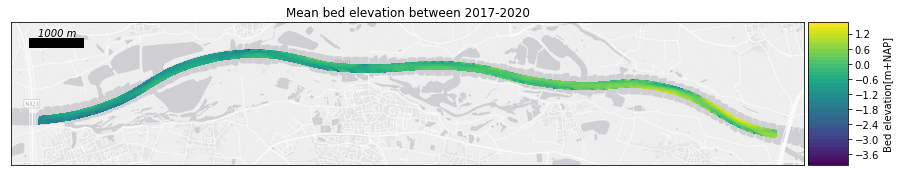

In [9]:
fig,ax = plt.subplots(figsize=(15,7.5))
buffer = 600

map = ax.contourf(X[:,:],Y[:,:],Zmean[:,:],50)
ax.set_aspect('equal')
ax.set_title(f'Mean bed elevation between 2017-2020')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
cbar = fig.colorbar(map,cax=cax)
cbar.set_label('Bed elevation[m+NAP]')

ax.set_xlim([np.min(X)-buffer,np.max(X)+buffer])
ax.set_ylim([np.min(Y)-buffer,np.max(Y)+buffer])

xlims = ax.get_xlim()
ylims = ax.get_ylim()

bbox = [xlims[0],ylims[0],xlims[1],ylims[1]]
box1 = box(*bbox)
kaart = get_topo_RD(bbox, 1000, maptype = 'Canvas')
ax.imshow(kaart, extent =  mpl_bbox(box1.bounds), interpolation ='lanczos')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.text(xlims[0]+600, ylims[1]-300, '1000 m', style='italic')
ax.plot([xlims[0]+500,xlims[0]+500+1000],[ylims[1]-450,ylims[1]-450], color = 'black', linewidth = 10)

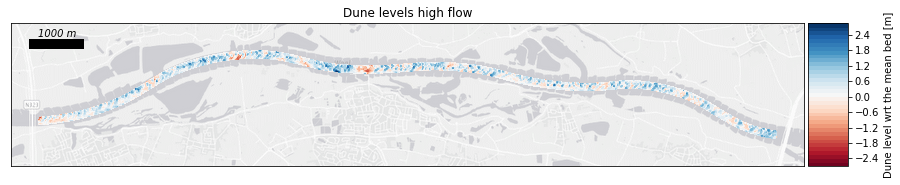

In [12]:
fig,ax = plt.subplots(figsize=(15,7.5))
buffer = 600

map = ax.contourf(X,Y,Zdune[:,:,6],50, cmap = 'RdBu')
ax.set_aspect('equal')
ax.set_title(f'Dune levels high flow')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
cbar = fig.colorbar(map,cax=cax)
cbar.set_label('Dune level wrt the mean bed [m]')

ax.set_xlim([np.min(X)-buffer,np.max(X)+buffer])
ax.set_ylim([np.min(Y)-buffer,np.max(Y)+buffer])

xlims = ax.get_xlim()
ylims = ax.get_ylim()

bbox = [xlims[0],ylims[0],xlims[1],ylims[1]]
box1 = box(*bbox)
kaart = get_topo_RD(bbox, 1000, maptype = 'Canvas')
ax.imshow(kaart, extent =  mpl_bbox(box1.bounds), interpolation ='lanczos')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.text(xlims[0]+600, ylims[1]-300, '1000 m', style='italic')
ax.plot([xlims[0]+500,xlims[0]+500+1000],[ylims[1]-450,ylims[1]-450], color = 'black', linewidth = 10)

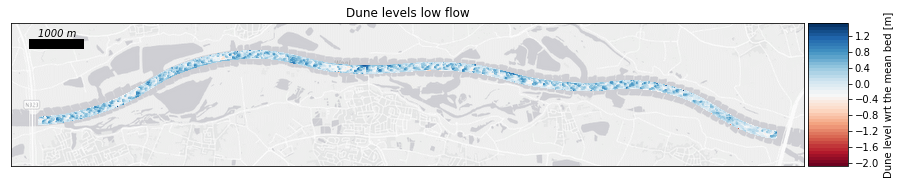

In [13]:
fig,ax = plt.subplots(figsize=(15,7.5))
buffer = 600

map = ax.contourf(X,Y,Zdune[:,:,19],50, cmap = 'RdBu')
ax.set_aspect('equal')
ax.set_title(f'Dune levels low flow')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
cbar = fig.colorbar(map,cax=cax)
cbar.set_label('Dune level wrt the mean bed [m]')

ax.set_xlim([np.min(X)-buffer,np.max(X)+buffer])
ax.set_ylim([np.min(Y)-buffer,np.max(Y)+buffer])

xlims = ax.get_xlim()
ylims = ax.get_ylim()

bbox = [xlims[0],ylims[0],xlims[1],ylims[1]]
box1 = box(*bbox)
kaart = get_topo_RD(bbox, 1000, maptype = 'Canvas')
ax.imshow(kaart, extent =  mpl_bbox(box1.bounds), interpolation ='lanczos')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.text(xlims[0]+600, ylims[1]-300, '1000 m', style='italic')
ax.plot([xlims[0]+500,xlims[0]+500+1000],[ylims[1]-450,ylims[1]-450], color = 'black', linewidth = 10)

## go to 03_WaveletAnalysis